In [1]:
# Enable automatic import reloading
%load_ext autoreload
%autoreload 2

# Display outputs from all lines when they exist
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # "last"

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import pickle
import pandas as pd
import seaborn as sns

import triadicsim


In [155]:
def get_filename(graph_type, closure_method, experiment_type, value, ):
    if experiment_type == 'threshold':
        value = "{:.1f}".format(value)

    filename = f'{graph_type}_model{closure_method}_{experiment_type}{value}.pkl'
    
    dirnames = ["e1_v2_hyperparam", "e1_v3_hyperparam", "e1_hyperparam"]
    
    for dirname in dirnames:
        if filename in os.listdir(dirname):
            return os.path.join(dirname, filename)
    raise ValueError(f'can\'t find {filename} in any of the directories specified')
    

def filter_df(df, filter_d):
    for k, v in filter_d.items():
        df = df[df[k] == v]
    return df

In [157]:
# # Look at what's in the directory
foo = os.listdir("e1_v2_hyperparam")
sorted(foo)

['gnp_modelmax_closure1.pkl',
 'gnp_modelmax_closure10.pkl',
 'gnp_modelmax_closure100.pkl',
 'gnp_modelmax_closure25.pkl',
 'gnp_modelmax_closure250.pkl',
 'gnp_modelmax_closure5.pkl',
 'gnp_modelmax_closure50.pkl',
 'gnp_modelmax_closure500.pkl',
 'gnp_modelmax_closure75.pkl',
 'gnp_modelpop_closure1.pkl',
 'gnp_modelpop_closure10.pkl',
 'gnp_modelpop_closure100.pkl',
 'gnp_modelpop_closure25.pkl',
 'gnp_modelpop_closure250.pkl',
 'gnp_modelpop_closure5.pkl',
 'gnp_modelpop_closure50.pkl',
 'gnp_modelpop_closure500.pkl',
 'gnp_modelpop_closure75.pkl',
 'gnp_modelrandom_closure1.pkl',
 'gnp_modelrandom_closure10.pkl',
 'gnp_modelrandom_closure100.pkl',
 'gnp_modelrandom_closure25.pkl',
 'gnp_modelrandom_closure250.pkl',
 'gnp_modelrandom_closure5.pkl',
 'gnp_modelrandom_closure50.pkl',
 'gnp_modelrandom_closure500.pkl',
 'gnp_modelrandom_closure75.pkl',
 'gnp_modelstatic_closure1.pkl',
 'gnp_modelstatic_closure10.pkl',
 'gnp_modelstatic_closure100.pkl',
 'gnp_modelstatic_closure25.pkl

Constants

In [159]:
graph_types = ["gnp", "gnpmini", "smb"]
closure_methods= ['pop', 'static', 'random', 'max', ]
experiment_types = ['closure', 'threshold']
threshold_vals = np.arange(0.1, 1, 0.1)
# closure_vals = [1, 5, 10, 15, 20, 25]
closure_vals = [1, 5, 10, 25, 50, 75, 100, 250, 500]
experiment_vals_d = {'closure': closure_vals,
                     'threshold':threshold_vals,
                    }
all_data = pd.DataFrame(columns=['max_size_rounds', 'rounds_filled', 'max_sizes', 
                                 'graph_type', 'closure_method', 'experiment_type', 'values'])
colors = [sns.xkcd_rgb['light red'], sns.xkcd_rgb['greenish'], sns.xkcd_rgb['denim'], sns.xkcd_rgb['purpleish blue'], sns.xkcd_rgb['bubblegum']]

## Read in data

In [166]:
old_all_data = all_data.copy(deep=True)

In [ ]:
SAVE=False
graph_type = "sbm"
for experiment_type in experiment_types:
    experiment_vals = experiment_vals_d[experiment_type]
    for i, closure_method in enumerate(closure_methods):

        all_max_size_rounds = []
        for experiment_val in experiment_vals:
            
            if len(filter_df(all_data, {
                'graph_type': graph_type,
                'closure_method': closure_method, 
                'experiment_type': experiment_type, 
                'values': experiment_val
            })) > 0: continue
            filename = get_filename(graph_type, closure_method, experiment_type, experiment_val)
            print(filename)
            (sim_log, rounds_filled, rounds_frozen, max_size_round, sizes_round) = pickle.load(
                open(filename, 'rb')
            )
            all_max_size_rounds.append(max_size_round)

            vals = {
                'max_size_rounds': np.array(max_size_round),
                'rounds_filled': np.array(rounds_filled),
                'max_sizes': np.array([max(x) for x in sizes_round]),
                'graph_type': graph_type,
                'closure_method': closure_method, 
                'experiment_type': experiment_type, 
                'values': experiment_val
            }
            all_data = all_data.append(vals, ignore_index=True)

if SAVE:
    all_data.to_pickle("all_data.pkl")

In [122]:
df = filter_df(all_data, {
    'graph_type': graph_type,
    'closure_method': closure_method, 
    'experiment_type': "closure",})
df.head()

,max_size_rounds,rounds_filled,max_sizes,graph_type,closure_method,experiment_type,values
78,"[16, 67, 100, 22, 8, 48, 0, 24, 58, 49, 18, 7,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.65, 0.9, 0.35, 0.4, 0.9, 0.8, 0.05, 0.95, 0...",gnpmini,max,closure,1
79,"[17, 12, 5, 14, 0, 4, 14, 18, 0, 1, 7, 8, 13, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.85, 0.95, 0.7, 0.9, 0.05, 0.65, 0.8, 0.85, ...",gnpmini,max,closure,5
80,"[1, 4, 3, 7, 11, 6, 4, 7, 5, 8, 6, 5, 0, 3, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1, 0.35, 0.45, 0.85, 0.9, 0.8, 0.25, 0.85, ...",gnpmini,max,closure,10
81,"[8, 4, 8, 0, 8, 9, 4, 5, 5, 6, 5, 5, 6, 10, 5,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.7, 0.85, 0.95, 0.05, 1.0, 0.1, 0.8, 0.7, 0....",gnpmini,max,closure,15
82,"[5, 7, 1, 4, 4, 3, 2, 5, 13, 7, 3, 10, 4, 6, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.3, 0.15, 0.1, 0.85, 0.65, 0.1, 0.15, 0.8, 0...",gnpmini,max,closure,20


/var/folders/cg/yfyy6nkx6jd8r_wqrhbygzkh0000gn/T/ipykernel_60763/1216129429.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(x) for x in closure_vals]);


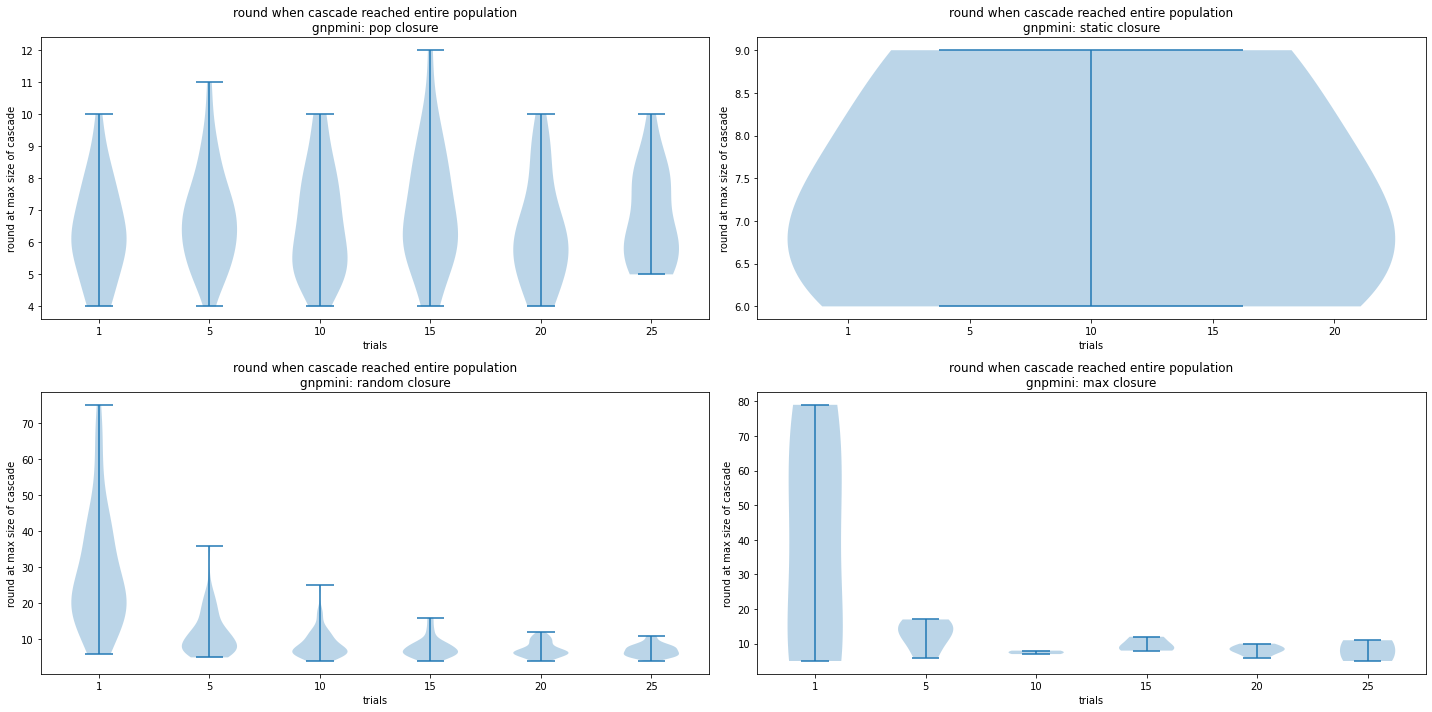

In [145]:
f, axs = plt.subplots(2, 2, figsize=(20, 10))
PLOT_TYPE= 'violin' # 'hist', 'violin', 'box'

for i, closure_method in enumerate(closure_methods):
    ax = axs[i//2, i%2]
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': "closure"})
    
    if PLOT_TYPE != 'hist':
        all_round_when_complete = []
    for i, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        if len(round_when_complete) == 0:
            continue
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        if PLOT_TYPE == 'hist':
            ax.hist(round_when_complete, label=row['values'], alpha=0.5);
        else:
            all_round_when_complete.append(round_when_complete)
    if PLOT_TYPE == 'violin':
        ax.violinplot(all_round_when_complete)
    elif PLOT_TYPE == 'box':
        ax.boxplot(all_round_when_complete)
        
    if PLOT_TYPE == 'hist':
        ax.legend(loc='upper right');
        ax.set_xlabel('round at max size of cascade');
        ax.set_ylabel('trials');

    elif PLOT_TYPE == 'violin':
        ax.set_xticklabels([''] + [str(x) for x in closure_vals]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('number of added edges per round');
    elif PLOT_TYPE == 'box':
        ax.set_xticklabels([str(x) for x in closure_vals]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('number of added edges per round');
        
    ax.set_ylabel('round at max size of cascade');
    ax.set_xlabel('trials');
    ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();


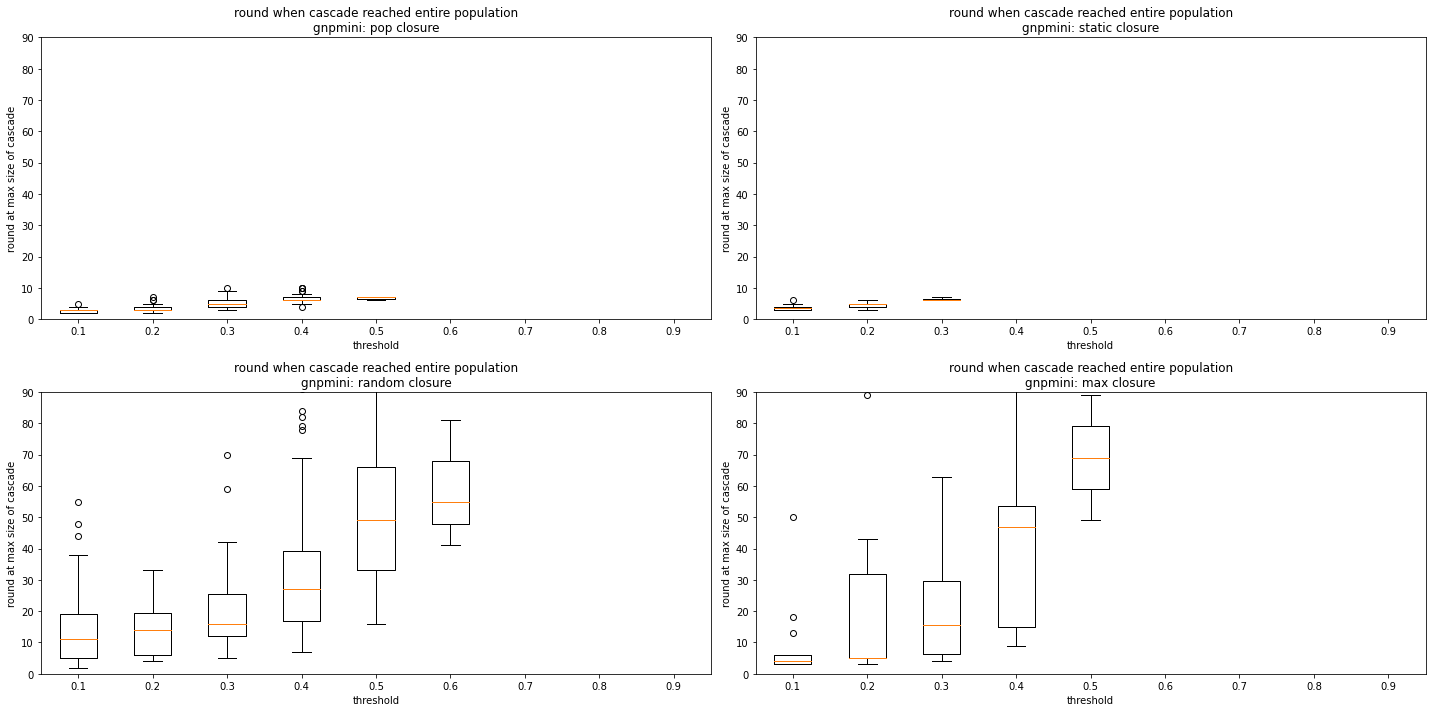

In [146]:
f, axs = plt.subplots(2, 2, figsize=(20, 10))
PLOT_TYPE= 'box' # 'hist', 'violin', 'box'
experiment_type = 'threshold'

for i, closure_method in enumerate(closure_methods):
    ax = axs[i//2, i%2]
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': experiment_type })
    
    if PLOT_TYPE != 'hist':
        all_round_when_complete = []
    for i, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        if PLOT_TYPE == 'hist':
            ax.hist(round_when_complete, label="{:0.1f}".format(row['values']), alpha=0.5);
        else:
            all_round_when_complete.append(round_when_complete)
    if PLOT_TYPE == 'violin':
        ax.violinplot(all_round_when_complete)
    elif PLOT_TYPE == 'box':
        ax.boxplot(all_round_when_complete)
        
    if PLOT_TYPE == 'hist':
        ax.legend(loc='upper right');
        ax.set_xlabel('threshold');
        ax.set_ylabel('trials');
    elif PLOT_TYPE == 'violin':
        ax.set_xticklabels([''] + ["{:0.1f}".format(x) for x in experimet_vals_d[experiment_type]]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('threshold');
        ax.set_ylim([0, 90])
    elif PLOT_TYPE == 'box':
        ax.set_xticklabels(["{:0.1f}".format(x) for x in experiment_vals_d[experiment_type]]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('threshold');
        ax.set_ylim([0, 90])
        
    ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();


In [147]:
def box_plot(ax, data, edge_color, label):
    bp = ax.boxplot(data, patch_artist=True, label=label)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    # for patch in bp['boxes']:
        # patch.set(facecolor=fill_color)       
        
    return bp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


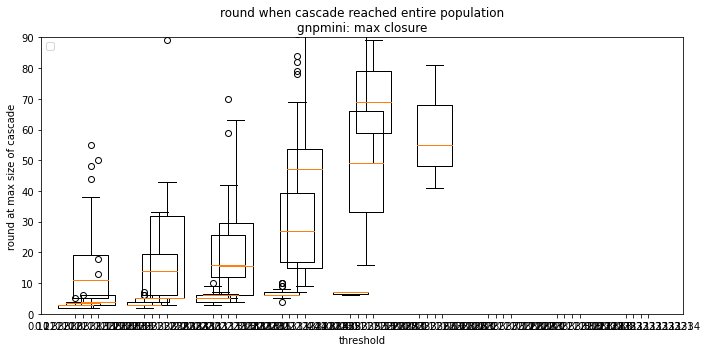

In [148]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
experiment_type = 'threshold'
experiment_vals = experiment_vals_d[experiment_type]
for i, closure_method in enumerate(closure_methods):
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': experiment_type })
    
    all_round_when_complete = []
    for _, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        all_round_when_complete.append(round_when_complete)
    ax.boxplot(all_round_when_complete, positions=np.arange(0+i/len(experiment_vals), len(experiment_vals) + i/len(experiment_vals), 1))
    # box_plot(ax, all_round_when_complete, colors[i], closure_method)
        
ax.legend(loc='upper left');
# ax.set_xticklabels(["{:0.1f}".format(x) for x in experiment_vals_d[experiment_type]]);
ax.set_ylabel('round at max size of cascade');
ax.set_xlabel('threshold');
ax.set_ylim([0, 90])
        
ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();


## Plot gnp vs stochastic vs. population

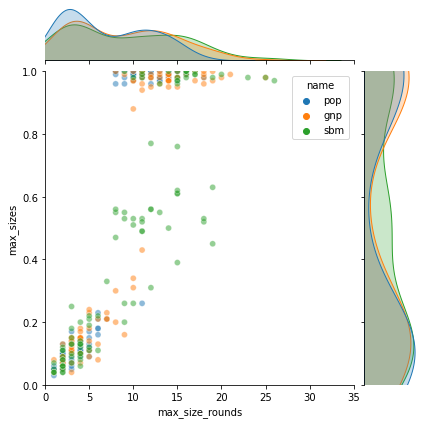

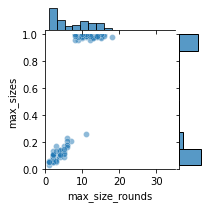

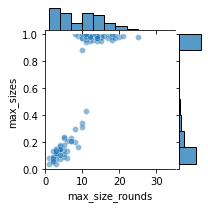

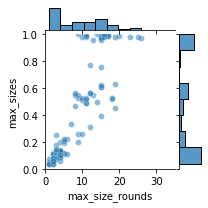

In [228]:
experiment_type = 'closure'
experiment_val = 1

graph_type_closure_methods = [('gnp', 'pop', 'pop'), ('gnp', 'static', 'gnp'), ('sbm', 'static', 'sbm')]

data = pd.DataFrame(columns=['max_size_rounds', 'rounds_filled', 'max_sizes', 'name'])

                              
for graph_type, closure_method, name in graph_type_closure_methods:
    filename = get_filename(graph_type, closure_method, experiment_type, experiment_val)
    print(filename)
    (sim_log, rounds_filled, rounds_frozen, max_size_round, sizes_round) = pickle.load(
        open(filename, 'rb')
    )

    for max_size_round, rounds_filled, max_size in zip(np.array(max_size_round),
                                                       np.array(rounds_filled),
                                                       np.array([max(x) for x in sizes_round])):
        vals = {
            'max_size_rounds': max_size_round,
            'rounds_filled': rounds_filled,
            'max_sizes': max_size,
            'name': name,
        } 
        data = data.append(vals, ignore_index=True)

g = sns.jointplot(data=data, x="max_size_rounds", y="max_sizes", hue='name',
                  xlim=(0, 35),
                  ylim=(0, 1), alpha=0.5,
                 );#, kind="hist");
# g.legend(loc='lower right');

# plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");
f = g.fig
# f.xlabel('max size round');
# f.ylabel('max size');
f.savefig("fig/gnp-stochastic-population")

for name in ['pop', 'gnp', 'sbm']:
    df = filter_df(data, {'name': name})
    g = sns.jointplot(data=df, x="max_size_rounds", y="max_sizes",
                      xlim=(0, 35),
                      ylim=(0, 1), 
                      height=3,
                      kind='scatter',alpha=0.5);

    # plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");
    f = g.fig
    # f.xlabel('max size round');
    # f.ylabel('max size');
    f.savefig(f"fig/gnp-stochastic-population-{name}")

In [123]:
graph_type = 'gnpmini'
experiment_type = 'closure'
experiment_val = 25

df = filter_df(all_data, {'graph_type': graph_type,
                          'experiment_type': experiment_type,
                          'values': experiment_val
                         })

pop
total trials that went to whole population: 26
static
total trials that went to whole population: 0
random
total trials that went to whole population: 59
max
total trials that went to whole population: 2


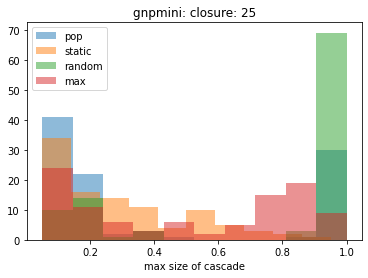

In [126]:
for i, row in df.iterrows():
    print(row['closure_method'])
    print(f"total trials that went to whole population: {np.sum(row['rounds_filled'])}")
    plt.hist(row['max_sizes'], label=row['closure_method'], alpha=0.5);
plt.legend(loc='upper left');
plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");
plt.xlabel("max size of cascade");

Plot difference to population

In [127]:
max_size_rounds_closure = {}
for i, row in df.iterrows():
    max_size_rounds_closure[row['closure_method']] = row['max_size_rounds']

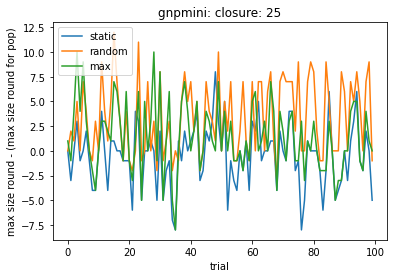

In [128]:
for k, v in max_size_rounds_closure.items():
    if k == 'pop': continue
    plt.plot(v - max_size_rounds_closure['pop'], label=k)
plt.legend(loc='upper left')
plt.xlabel('trial')
plt.ylabel('max size round - (max size round for pop)')
plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");

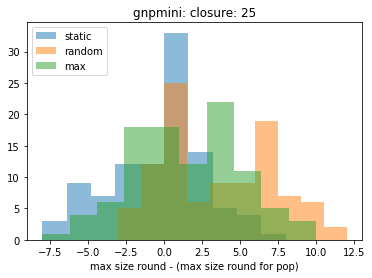

In [129]:
for k, v in max_size_rounds_closure.items():
    if k == 'pop': continue
    plt.hist(v - max_size_rounds_closure['pop'], label=k, alpha=0.5);
plt.legend(loc='upper left');
plt.xlabel('max size round - (max size round for pop)');
plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");

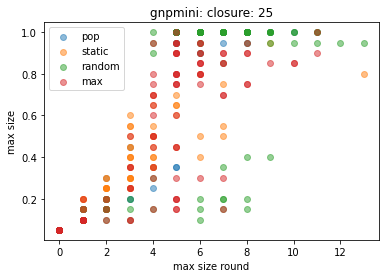

In [130]:
for i, row in df.iterrows():
    plt.scatter(row['max_size_rounds'], row['max_sizes'], label=row['closure_method'], alpha=0.5);
plt.xlabel('max size round');
plt.ylabel('max size');
plt.legend(loc='upper left');
plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");

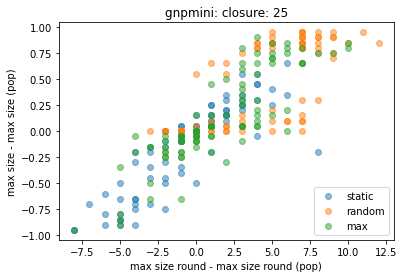

In [131]:
for i, row in df.iterrows():
    if row['closure_method'] != 'pop': continue
    pop_max_size_rounds = row['max_size_rounds']
    pop_max_sizes = row['max_sizes']
    
for i, row in df.iterrows():
    if row['closure_method'] == 'pop': continue
    plt.scatter(row['max_size_rounds'] - pop_max_size_rounds,
                row['max_sizes'] - pop_max_sizes,
                label=row['closure_method'], alpha=0.5);
plt.xlabel('max size round - max size round (pop)');
plt.ylabel('max size - max size (pop)');
plt.legend(loc='lower right');
plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");

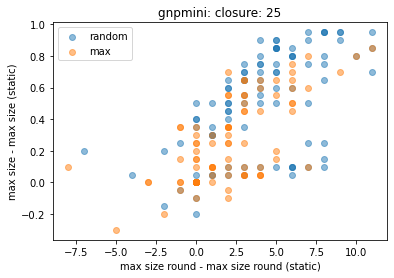

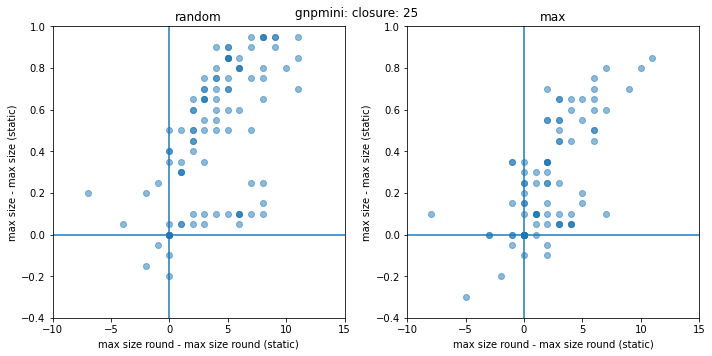

In [143]:
for i, row in df.iterrows():
    if row['closure_method'] != 'static': continue
    static_max_size_rounds = row['max_size_rounds']
    static_max_sizes = row['max_sizes']
    
for i, row in df.iterrows():
    if row['closure_method'] == 'pop': continue
    if row['closure_method'] == 'static': continue
    plt.scatter(row['max_size_rounds'] - static_max_size_rounds,
                row['max_sizes'] - static_max_sizes,
                label=row['closure_method'], alpha=0.5);
plt.xlabel('max size round - max size round (static)');
plt.ylabel('max size - max size (static)');
plt.legend(loc='upper left');
plt.title(f"{graph_type}: {experiment_type}: {experiment_val}");
plt.show();

f, axs = plt.subplots(1, 2, figsize=(10,5))
for _, row in filter_df(df, {'closure_method': 'random'}).iterrows():
    axs[0].scatter(row['max_size_rounds'] - static_max_size_rounds,
                   row['max_sizes'] - static_max_sizes,
                   label=row['closure_method'], alpha=0.5);
    axs[0].set_title('random')
for _, row in filter_df(df, {'closure_method': 'max'}).iterrows():
    axs[1].scatter(row['max_size_rounds'] - static_max_size_rounds,
                   row['max_sizes'] - static_max_sizes,
                   label=row['closure_method'], alpha=0.5);
    axs[1].set_title('max')
    
for ax in axs:
    ax.set_xlabel('max size round - max size round (static)');
    ax.set_ylabel('max size - max size (static)');
    ax.set_ylim([-0.4, 1]);
    ax.set_xlim([-10, 15]);
    ax.hlines(0, -10, 20);
    ax.vlines(0, -0.4, 1);
f.tight_layout();
plt.suptitle(f"{graph_type}: {experiment_type}: {experiment_val}");
